Submission by
* Govind Saju (200070020)
* Virendra Kabra (200050157)

# Initial Setup

In [1]:
import pandas as pd
import numpy as np
import sklearn

In [2]:
# Reading the given data files
stocks = pd.read_csv('data_challenge_stock_prices.csv')
index = pd.read_csv('data_challenge_index_prices.csv')

In [3]:
# A function to read a dataframe in the format of the files given, and provides the return of the stock/index in BPS
def getBPS(df):
    mat = df.to_numpy()
    returns = (mat[1:] - mat[:len(mat)-1])/mat[:len(mat)-1]
    return returns * 10000

In [4]:
st = getBPS(stocks)
indices = getBPS(index)

# Classifying stocks into sectors

In order to perform this classification, we utilised the pearson correlation coefficient of two stocks to compare how similar they are. Initially, we are unaware how many different sectors exist. We use a simple heuristic for identifying sectors - a stock will likely be in the same sector as the other stock it is most correlated to. 

In [5]:
from scipy import stats

In [6]:
corr = np.zeros((100,100)) #corr[i][j] will store the correlation of stocks i,j
for i in range(100):
    for j in range(100):
        if i<j:
          corr[i][j] = stats.pearsonr(st[:,i],st[:,j])[0]
        elif i==j:
          corr[i][j] = 1
        else:
          corr[i][j] = corr[j][i]

In [7]:
maxcorr = np.zeros(100,dtype=np.int32) # Maxcorr[i] will store the index of the stock the stock i has the highest correlation with (except itself)
for i in range(100):
    ind = (i+1)%100
    for j in range(100):
        if i==j:
            continue
        if corr[i][j]>corr[i][ind]:
            ind = j
    maxcorr[i] = ind

In [8]:
set(maxcorr)

{88, 90, 91, 95, 96, 97, 98, 99}

From these, we see there are only a few stocks and most other stocks are highly related to one of these stocks. Hence, we divide them into buckets based on this.

In [9]:
buckets = {i:[] for i in maxcorr}
for i in range(100):
    buckets[maxcorr[i]].append(i)
for i in buckets:
    print(i,buckets[i])

88 [0, 4, 11, 14, 18, 20, 21, 22, 25, 26, 38, 39, 43, 45, 49, 54, 67, 75, 78, 79, 82, 90]
90 [1, 10, 88]
98 [2, 3, 6, 7, 9, 16, 17, 19, 23, 28, 32, 33, 42, 47, 51, 53, 58, 60, 63, 66, 72, 81, 87, 91]
97 [5, 13, 15, 24, 31, 34, 35, 37, 48, 56, 61, 62, 64, 65, 68, 70, 76, 83, 85, 86, 89, 93, 94, 95]
99 [8, 12, 27, 29, 30, 36, 40, 41, 44, 46, 50, 52, 55, 57, 59, 69, 71, 73, 74, 77, 80, 84, 92, 96]
95 [97]
91 [98]
96 [99]


From these, we observe there are 4 major sectors - those from stocks 88, 97, 98 and 99. 90 is in the same bucket as 88, hence those stocks in its bucket can be added to the 88 bucket. 91, 95 and 96 are already in the other buckets. Hence, we have a total of 4 buckets / sectors.

In [10]:
#Implementing the details outlined in the text
buckets[88].extend(buckets[90])
buckets.pop(90)
buckets.pop(95)
buckets.pop(91)
buckets.pop(96)
buckets[98].append(98)
buckets[97].append(97)
buckets[99].append(99)

In [11]:
sectors = []
for i in buckets:
    sectors.append(buckets[i])
sectors = np.array(sectors)
print(sectors)

[[ 0  4 11 14 18 20 21 22 25 26 38 39 43 45 49 54 67 75 78 79 82 90  1 10
  88]
 [ 2  3  6  7  9 16 17 19 23 28 32 33 42 47 51 53 58 60 63 66 72 81 87 91
  98]
 [ 5 13 15 24 31 34 35 37 48 56 61 62 64 65 68 70 76 83 85 86 89 93 94 95
  97]
 [ 8 12 27 29 30 36 40 41 44 46 50 52 55 57 59 69 71 73 74 77 80 84 92 96
  99]]


Thus, we have hypothesised that there are 4 sectors, each containing 25 stocks apiece. In order to test our hypothesis, we plot heatmaps of the correlation between the stocks of different sectors.

In [12]:
# A helper function to generate these plots
def correlation(vec1, vec2):
    dim1 = vec1.shape[1]
    dim2 = vec2.shape[1]
    correl = np.zeros((dim1,dim2),dtype=np.float32)
    for i in range(dim1):
        for j in range(dim2):
            correl[i][j] = stats.pearsonr(vec1[:,i],vec2[:,j])[0]
    return correl

In [13]:
import seaborn as sbn
import matplotlib.pyplot as plt

In [14]:
stock_sectorwise = np.array([st[:,sectors[i]] for i in range(4)]) # To store the timeseries data of each sector for easy retrieval

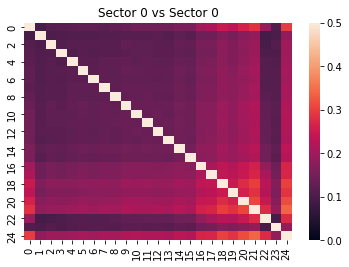

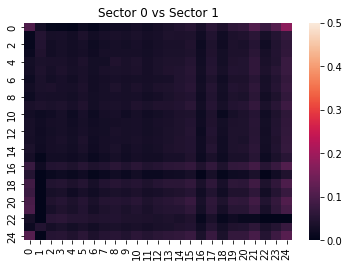

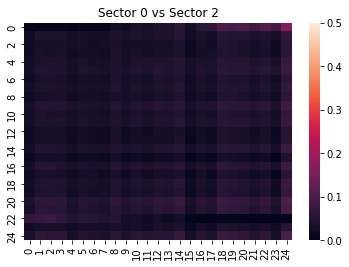

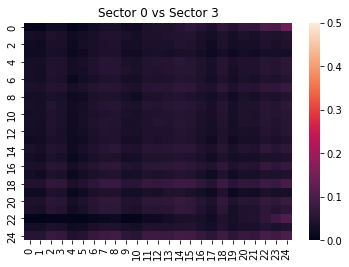

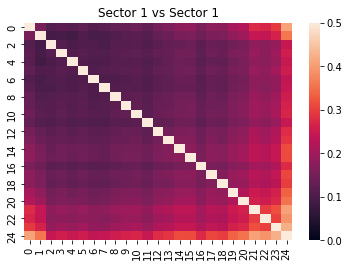

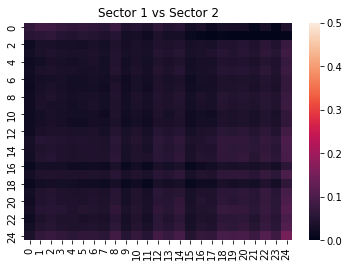

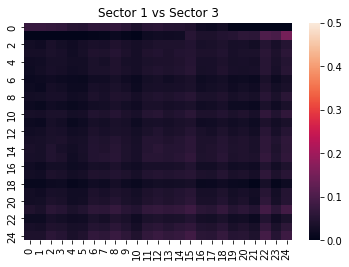

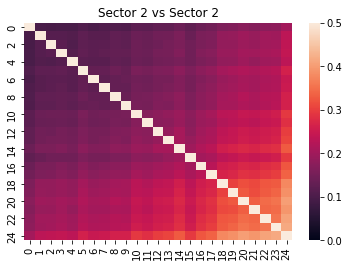

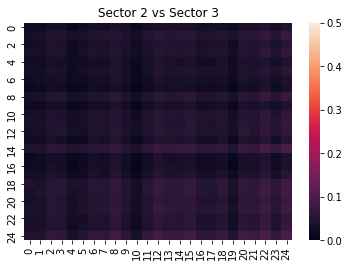

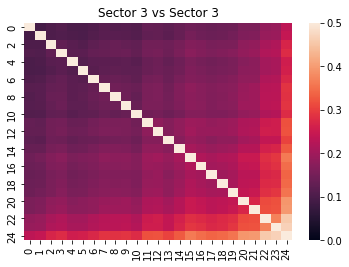

In [15]:
for i in range(4):
    for j in range(i,4):
        plt.title(f"Sector {i} vs Sector {j}")
        sbn.heatmap(correlation(stock_sectorwise[i],stock_sectorwise[j]),vmin=0,vmax=0.5)
        plt.show()

The generated plots show that the sectorwise classification is likely to be correct, as there is negligible correlation between the stocks of different sectors, while there is significant correlation between the stocks in the same sector.


# Predicting which sector each index belongs to

In order to predict which index belongs to which sector, we intend to train a simple model, and see whether any learning is happening. If the index is being trained on the right sector, then there would be improvements in the prediction correlation, whereas in the other sectors, there would be no correlation as the two statistics are independent. We first try a simple linear model to begin with.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

In [17]:
def test(Func):   
    pred_corr = np.zeros((15,4))
    for i in range(4):
        for j in range(15):
            x = stock_sectorwise[i]     # 199999,25
            y = indices                 # 199999,1
            x_tr = x[0:12000]
            x_te = x[12000:]
            y_tr = y[0:12000,j]
            y_te = y[12000:,j]
            model = Func()
            model.fit(x_tr,y_tr)
            y_pred = model.predict(x_te)
            pecorr = stats.pearsonr(y_te[:],y_pred[:])[0]
            pred_corr[j][i] = pecorr
    
    posn = np.argmax(pred_corr,axis=1)
    for i in range(15):
        print(i,pred_corr[i],posn[i])


In [18]:
print("Linear")
test(LinearRegression)

Linear
0 [0.44428666 0.08731293 0.08200398 0.08465401] 0
1 [0.05599844 0.05183528 0.31142448 0.05264355] 2
2 [0.20657407 0.01151913 0.01726661 0.01918735] 0
3 [0.0298753  0.34350168 0.02661995 0.02855217] 1
4 [0.09505984 0.07339035 0.08738046 0.44746208] 3
5 [0.01818233 0.0265306  0.21575747 0.0275874 ] 2
6 [0.08724768 0.44362346 0.09761592 0.08195443] 1
7 [0.30144975 0.05163767 0.05164508 0.05090786] 0
8 [0.04894639 0.30381171 0.05049344 0.05297393] 1
9 [0.02944939 0.02110999 0.03250083 0.34517321] 3
10 [0.01015871 0.02096384 0.3408217  0.01171519] 2
11 [-0.00015145  0.00158011 -0.00180775 -0.00240251] 1
12 [ 0.00549766 -0.00246269  0.00126297 -0.00114666] 0
13 [-0.00341212  0.00479849  0.00124561 -0.00108384] 1
14 [0.01209144 0.00158175 0.00911624 0.20853675] 3


From the above data, we are able to obtain the sectors for all indices except indices 11,12 and 13. A more complex model may be needed in this segment. We try out a simple neural network (aka multi layer perceptron or MLP in sklearn) for these.

In [19]:
print("MLP")
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")     # This is needed as we do not expect full convergence of the model,
                                        # we only wish to see in which sector it is learning from.
    test(MLPRegressor)

MLP
0 [0.29163925 0.01707298 0.01973109 0.02904094] 0
1 [0.01279839 0.00608836 0.22103787 0.00386441] 2
2 [ 0.38081152  0.00452805  0.00735969 -0.00093521] 0
3 [ 0.00196871  0.31471257 -0.00201379  0.01277601] 1
4 [0.0147157  0.00898068 0.0088623  0.30836637] 3
5 [ 0.00910079 -0.00528372  0.38154642  0.00175844] 2
6 [0.01286464 0.30061082 0.01561245 0.01697052] 1
7 [0.22846705 0.0106959  0.00282917 0.00379129] 0
8 [0.00136504 0.2559067  0.00139402 0.01595833] 1
9 [0.00965886 0.00299851 0.00094139 0.3057748 ] 3
10 [ 0.00366227 -0.00158355  0.3184435   0.0049074 ] 2
11 [ 0.30345044  0.00135102 -0.00108709  0.00349527] 0
12 [ 0.00104688 -0.00071054  0.00198147  0.27860135] 3
13 [ 0.00347034  0.30176857  0.0047987  -0.00146851] 1
14 [4.47451247e-03 2.68727715e-04 4.46259318e-03 3.82426254e-01] 3


From the above experiments, we can deduce the sectors for each index. For future use, we store them in the following dictionary.

In [20]:
index_sector = {0:0,1:2,2:0,3:1,4:3,5:2,6:1,7:0,8:1,9:3,10:2,11:0,12:3,13:1,14:3}

# Creating models for each index

In this section, we first create a function for training and evaluating different models. We also add some insights we obtained for some of the sectors.

We use the first 160000 steps as training data, and evaluate our predictive correlation of the models on the next 20000 steps.

In [21]:
def train_and_evaluate(ind_num,sector_num,train_len,test_len,model, do_scale=False, do_poly=-1):
    train_x = stock_sectorwise[sector_num][:train_len]
    train_y = indices[:train_len,ind_num]
    test_x = stock_sectorwise[sector_num][train_len:train_len+test_len]
    test_y = indices[train_len:train_len+test_len,ind_num]

    if do_scale:
        # scale data
        scaler = sklearn.preprocessing.MinMaxScaler().fit(train_x)
        train_x = scaler.transform(train_x)
        test_x = scaler.transform(test_x)

    if do_poly != -1:
        # use polynomial features
        poly = sklearn.preprocessing.PolynomialFeatures(degree=do_poly)
        train_x = poly.fit_transform(train_x)
        test_x = poly.fit_transform(test_x)

    model.fit(train_x,train_y)
    y_pred = model.predict(test_x)
    pecorr = stats.pearsonr(test_y,y_pred)[0]
    print(f"Predictive correlation for index {ind_num} : {pecorr}")
    return model

In [22]:
train_len = 160000-1
test_len = 20000

In [23]:
#Index 0:
#Linear Model

ind_num = 0
sector_num = index_sector[ind_num]
mod0 = LinearRegression()

mod0 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod0)

Predictive correlation for index 0 : 0.4407120849740961


In [24]:
#Index 1:
#Neural Net
ind_num = 1
sector_num = index_sector[ind_num]
mod1 = MLPRegressor(hidden_layer_sizes=(100))
mod1 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod1, do_scale=True)

Predictive correlation for index 1 : 0.4202956228958846


In [25]:
#Index 2:
#Neural Net
ind_num = 2
sector_num = index_sector[ind_num]
mod2 = MLPRegressor(hidden_layer_sizes=(20))
mod2 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod2)

Predictive correlation for index 2 : 0.5940931564130454


In [26]:
#Index 3:
#Neural Net
ind_num = 3
sector_num = index_sector[ind_num]
mod3 = MLPRegressor(hidden_layer_sizes=(5))
mod3 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod3)

Predictive correlation for index 3 : 0.4427932468140391


In [27]:
#Index 4:
#Linear Model
ind_num = 4
sector_num = index_sector[ind_num]
# mod4 = LinearRegression()
mod4 = MLPRegressor(hidden_layer_sizes=20)
mod4 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod4)

Predictive correlation for index 4 : 0.4457420841839246


In [28]:
#Index 5:
#Neural Net
ind_num = 5
sector_num = index_sector[ind_num]
mod5 = MLPRegressor(hidden_layer_sizes=(10))
mod5 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod5)

Predictive correlation for index 5 : 0.5488166820135458


In [29]:
#Index 6:
#Neural Net
ind_num = 6
sector_num = index_sector[ind_num]
mod6 = MLPRegressor(hidden_layer_sizes=(5))
mod6 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod6)

Predictive correlation for index 6 : 0.4487878113929495


In [30]:
#Index 7:
#Neural Net
ind_num = 7
sector_num = index_sector[ind_num]
mod7 = MLPRegressor(hidden_layer_sizes=(80))
mod7 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod7)

Predictive correlation for index 7 : 0.40410531360208485


In [31]:
#Index 8:
#Neural Net
ind_num = 8
sector_num = index_sector[ind_num]
mod8 = MLPRegressor(hidden_layer_sizes=(80))
mod8 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod8)

Predictive correlation for index 8 : 0.40974835433046425


In [32]:
#Index 9:
#Neural Net
ind_num = 9
sector_num = index_sector[ind_num]
mod9 = MLPRegressor(hidden_layer_sizes=(80))
mod9 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod9)

Predictive correlation for index 9 : 0.4312795402100326


In [33]:
#Index 10:
#Neural Net
ind_num = 10
sector_num = index_sector[ind_num]
mod10 = MLPRegressor(hidden_layer_sizes=(80))
mod10 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod10)

Predictive correlation for index 10 : 0.43883136152813396


In [34]:
#Index 11:
#Neural Net
ind_num = 11
sector_num = index_sector[ind_num]
mod11 = MLPRegressor(hidden_layer_sizes=(80))
mod11 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod11)

Predictive correlation for index 11 : 0.43367326863343564


In [35]:
#Index 12:
#Neural Net
ind_num = 12
sector_num = index_sector[ind_num]
mod12 = MLPRegressor(hidden_layer_sizes=(80))
mod12 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod12)

Predictive correlation for index 12 : 0.430872773313565


In [36]:
#Index 13:
#Neural Net
ind_num = 13
sector_num = index_sector[ind_num]
mod13 = MLPRegressor(hidden_layer_sizes=(80))
mod13 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod13)

Predictive correlation for index 13 : 0.42716806771811333


In [37]:
#Index 14:
#Neural Net
ind_num = 14
sector_num = index_sector[ind_num]
mod14 = MLPRegressor(hidden_layer_sizes=(20))
mod14 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod14)

Predictive correlation for index 14 : 0.5814217215401098


In [38]:
models = [mod0,mod1,mod2,mod3,mod4,mod5,mod6,mod7,mod8,mod9,mod10,mod11,mod12,mod13,mod14]
import joblib
import pathlib

pathlib.Path('models').mkdir(exist_ok=True)

for i,mod in enumerate(models):
    joblib.dump(mod, f'models/{i}.pkl')

In [39]:
# Uncomment if loading models trained during earlier runs
# import joblib
# models = []
# for i in range(15):
#     models.append(joblib.load(open(f'models/{i}.pkl','rb')))

# Predicting using the above models and covariance matrix construction

In [40]:
def predict(returns): #Takes stock returns as input, returns index return predictions.
    res = []
    for i in range(15):
        inp = returns[:,sectors[index_sector[i]]]
        res.append(models[i].predict(inp))
    
    return np.array(res).T

In [41]:
predictions = predict(st[train_len:])
covmat = ((predictions.T @ predictions)/len(predictions)) - np.outer(np.mean(predictions,axis=0),np.mean(predictions,axis=0))

We trade on the following sets
1. All indices
2. Indices for which models give >41% predictive correlation (implying better trained models)

In [42]:
all_indices = list(range(15))                      # point-1 from above
subset_of_indices = [0,2,3,4,5,6,9,10,11,12,13,14]     # point-2 from above

In [43]:
basev = train_len
timesteps = 200000-1-basev

## Trading Strategy

- Below is a linear-programming based trading strategy. Bounds and constraints are used, as mentioned in the statement
- We optimize on returns, or on sharpe

In [44]:
from scipy.optimize import minimize

def tradingstrategy(timesteps, pred, cov_submat, optimize):
  # To return a portfolio of length timesteps, containing the position of each index we're trading in at time T

    def objective_func(portfolio, predictions, optimize_for='returns'):
        returns = np.dot(portfolio, predictions)
        if optimize_for=='returns':
            return -returns
        elif optimize_for=='sharpe':
            var = np.dot(portfolio,np.dot(cov_submat, portfolio))
            return -returns/np.sqrt(var)
    
    portfolios = []
    for t in range(timesteps):
        return_pred = pred[t]
        init_guess = np.ones_like(return_pred)
        init_guess /= len(init_guess)

        # bound allocations in [-1,1]
        bounds = [(-1,1) for i in range(len(init_guess))]

        # all allocations must add up to zero
        constraints = ({"type": "eq", "fun": lambda x: np.sum(x)})
        
        portf = minimize(
            lambda wt:objective_func(wt, return_pred, optimize),
            init_guess,
            method="SLSQP",
            bounds=bounds,
            constraints=constraints).x
        portfolios.append(portf)

    return portfolios

Compute mean, standard deviation, and sharpe of the strategies

In [45]:
for optim in ['returns', 'sharpe']:
    for c,indices_to_trade in enumerate([all_indices,subset_of_indices]):
        if c==0:
            print("Trading on all indices",end=" ")
        else:
            print("Trading on a subset of indices",end=" ")
        stock_prices = st[basev:basev+timesteps]
        pred = predict(stock_prices)[:,indices_to_trade]
        cov_submat = covmat[indices_to_trade,:][:,indices_to_trade]
        portfolios = tradingstrategy(timesteps, pred, cov_submat, optim)
        index_prices = indices[basev:basev+timesteps, indices_to_trade]

        return_perc = []
        for a,b in zip(portfolios,index_prices):
            return_perc.append(np.dot(a,b))

        strat_mean = np.mean(return_perc)
        strat_std_dev = np.std(return_perc)
        strat_sharpe = strat_mean/strat_std_dev

        print(f"optimize: {optim} - mean: {round(strat_mean,2)}, standard deviation: {round(strat_std_dev,2)}, sharpe: {round(strat_sharpe,2)}")

Trading on all indices optimize: returns - mean: 9.6, standard deviation: 8.22, sharpe: 1.17
Trading on a subset of indices optimize: returns - mean: 9.08, standard deviation: 8.25, sharpe: 1.1
Trading on all indices optimize: sharpe - mean: 3.31, standard deviation: 2.92, sharpe: 1.13
Trading on a subset of indices optimize: sharpe - mean: 4.25, standard deviation: 3.41, sharpe: 1.25


## Experiments and Observations

We run the strategies on the last 40000 timesteps. BPS units are used.

As described above, we trade on
- all indices
- a subset of indices, based on predictive correlation

1. Optimizing for `return` on each timestep
    - Trading on all indices: `mean: 9.6, standard deviation: 8.22, sharpe: 1.17`
    - Trading on a subset of indices: `mean: 9.08, standard deviation: 8.25, sharpe: 1.1`
2. Optimizing for `return/std_dev` on each timestep
    - Trading on all indices: `mean: 3.31, standard deviation: 2.92, sharpe: 1.13`
    - Trading on a subset of indices: `mean: 4.25, standard deviation: 3.41, sharpe: 1.25`

As expected, the first strategy gives a higher mean, while the second lowers the standard deviation (a measure of the risk involved). Decrease in sharpe can be attributed to the noisy data, and predictions by models.

Trading on the subset of indices, we observe a higher sharpe with strategy-2. This is due to usage of more-reliable models.

Our models and strategies do not make any assumptions, other than those given:
- Given prices, returns are conditionally independent of previous returns
- Each index is a function of stocks only from a particular sector and conforms to the functional form given in equation-1 of the problem statement